# 🌀 RealNVP

In this notebook, we'll walk through the steps required to train your own RealNVP network to predict the distribution of a demo dataset

The code has been adapted from the excellent [RealNVP tutorial](https://keras.io/examples/generative/real_nvp) created by Mandolini Giorgio Maria, Sanna Daniele and Zannini Quirini Giorgio available on the Keras website.

In [3]:
%load_ext autoreload
%autoreload 2

%pip install --upgrade numpy matplotlib scikit-learn tensorflow tensorflow-probability
%pip install tf_keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)
import tensorflow_probability as tfp
tfd = tfp.distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 0. Parameters <a name="parameters"></a>

In [4]:
COUPLING_DIM = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

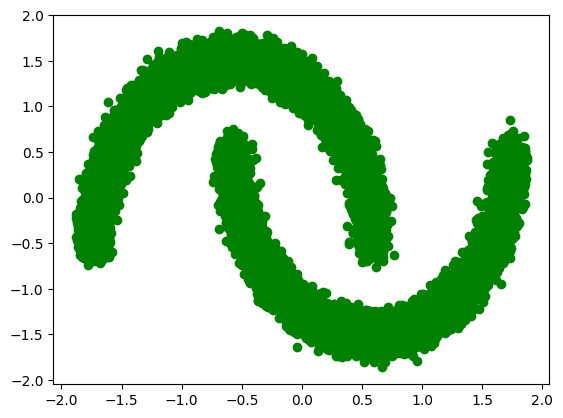

In [5]:
# Load the data
data = datasets.make_moons(30000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c="green"
)
plt.show()

## 2. Build the RealNVP network <a name="build"></a>

In [15]:
def Coupling(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=(input_dim,))

    s_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    s_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = layers.Dense(
        input_dim, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    t_layer_1 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input_layer)
    t_layer_2 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = layers.Dense(
        coupling_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = layers.Dense(
        input_dim, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [16]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=tf.zeros(input_dim), scale_diag=tf.ones(input_dim)
        )
        self.masks = np.array(
            [[0, 1] * (input_dim // 2), [1, 0] * (input_dim // 2)] * (coupling_layers // 2), dtype="float32"
        )
        self.masks = self.masks[:coupling_layers]  # Ensure the masks match the number of coupling layers
        self.masks = self.masks[:, :input_dim]  # Ensure the masks match the input dimension
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            Coupling(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, axis=1)
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

## 3. Train the RealNVP network <a name="train"></a>

In [17]:
# Compile and train the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [18]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(normalized_data)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            normalized_data[:, 0], normalized_data[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

Epoch 1/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3727
Saved to ./output/generated_img_000.png


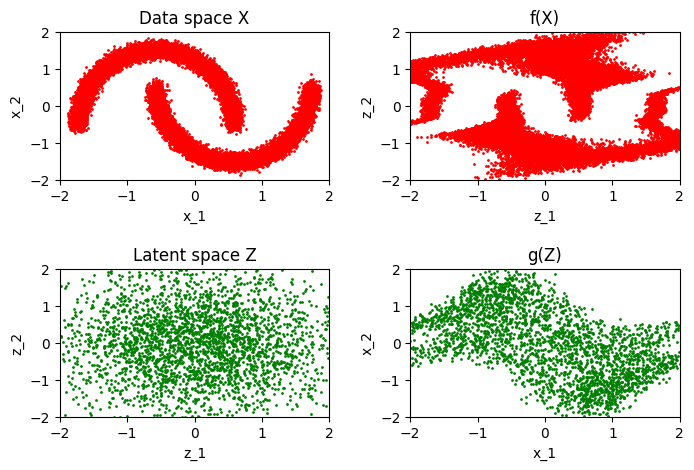

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.3713
Epoch 2/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.2148
Epoch 3/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.0751
Epoch 4/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.0215
Epoch 5/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.9802
Epoch 6/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.9183
Epoch 7/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.8320
Epoch 8/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7809
Epoch 9/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7641
Epoch 10/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7493
Epoch 11/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7451
Saved to ./output/generated_img_010.png


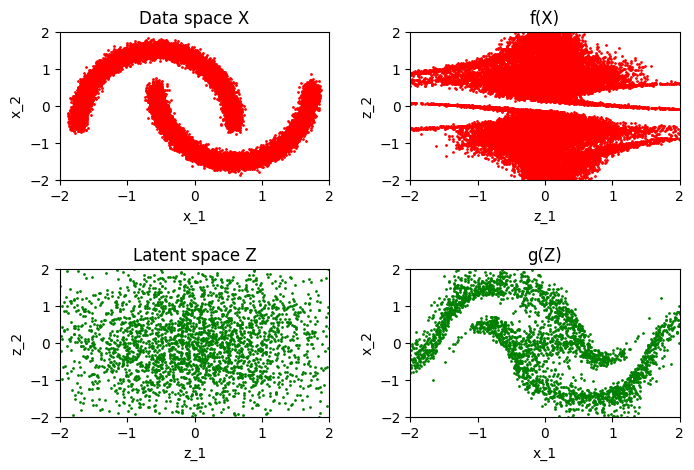

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7451
Epoch 12/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7372
Epoch 13/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7354
Epoch 14/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7319
Epoch 15/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7342
Epoch 16/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7440
Epoch 17/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7250
Epoch 18/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7350
Epoch 19/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7262
Epoch 20/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7272
Epoch 21/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7332
Saved to ./output/generated_img_020.png


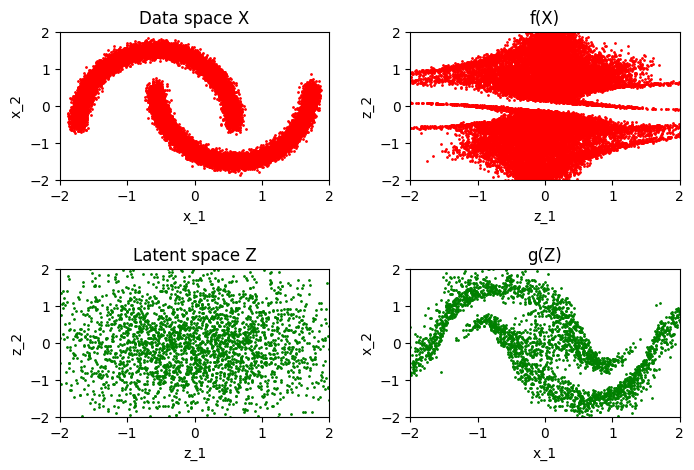

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7332
Epoch 22/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7280
Epoch 23/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7398
Epoch 24/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7356
Epoch 25/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7271
Epoch 26/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7128
Epoch 27/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7218
Epoch 28/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7044
Epoch 29/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7240
Epoch 30/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7310
Epoch 31/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7425
Saved to ./output/generated_img_030.png


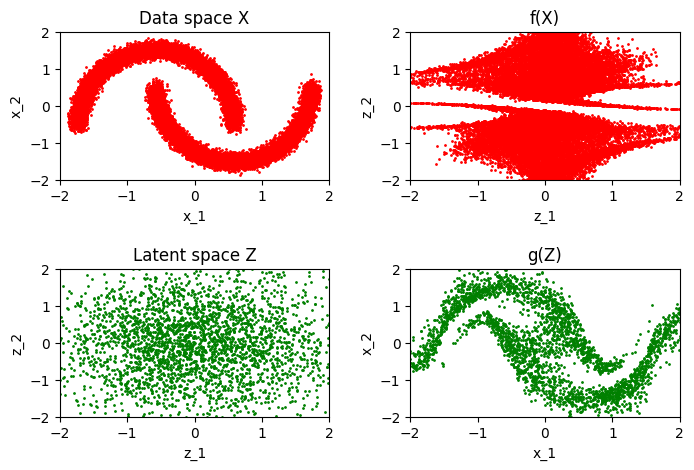

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7422
Epoch 32/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7258
Epoch 33/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7399
Epoch 34/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7071
Epoch 35/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7102
Epoch 36/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7251
Epoch 37/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7315
Epoch 38/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7198
Epoch 39/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7154
Epoch 40/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7167
Epoch 41/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7123
Saved to ./output/generated_img_040.png


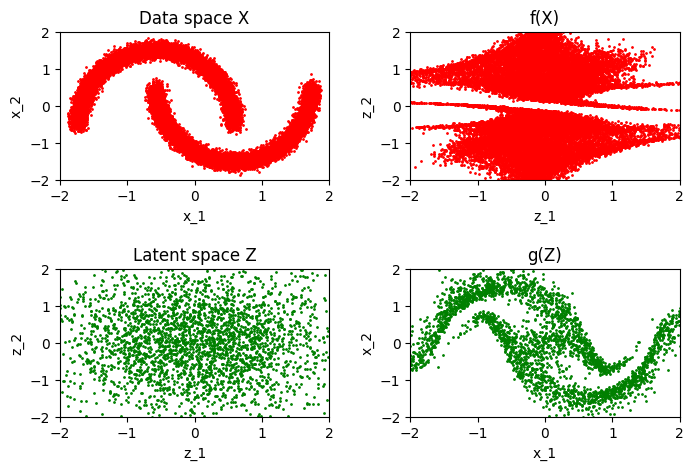

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.7125
Epoch 42/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7164
Epoch 43/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7303
Epoch 44/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7120
Epoch 45/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7189
Epoch 46/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7187
Epoch 47/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7057
Epoch 48/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7241
Epoch 49/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7114
Epoch 50/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7142
Epoch 51/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7191
Saved to ./output/generated_img_050.png


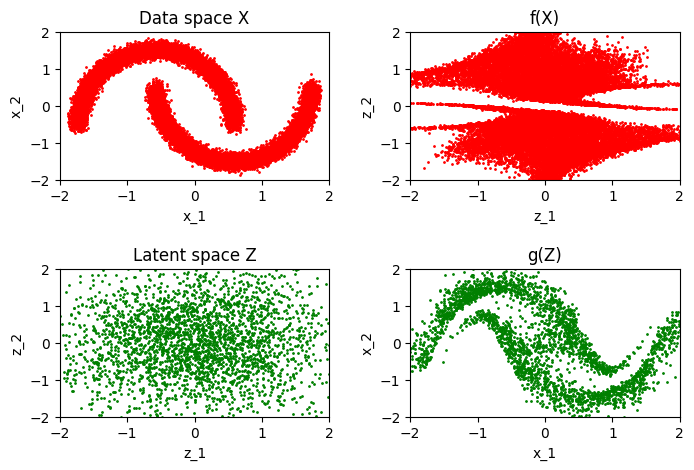

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7190
Epoch 52/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7174
Epoch 53/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7210
Epoch 54/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7173
Epoch 55/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7121
Epoch 56/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7234
Epoch 57/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7311
Epoch 58/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7145
Epoch 59/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7208
Epoch 60/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7102
Epoch 61/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7246
Saved to ./output/generated_img_060.png


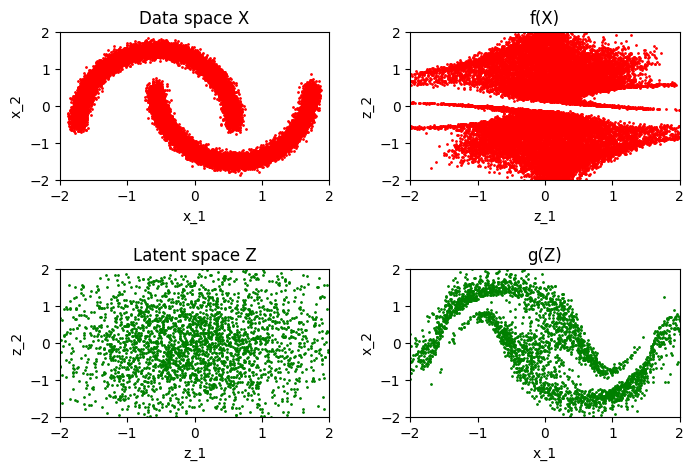

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7245
Epoch 62/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7073
Epoch 63/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7249
Epoch 64/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7049
Epoch 65/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7069
Epoch 66/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7047
Epoch 67/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7048
Epoch 68/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7116
Epoch 69/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7303
Epoch 70/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7126
Epoch 71/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7135
Saved to ./output/generated_img_070.png


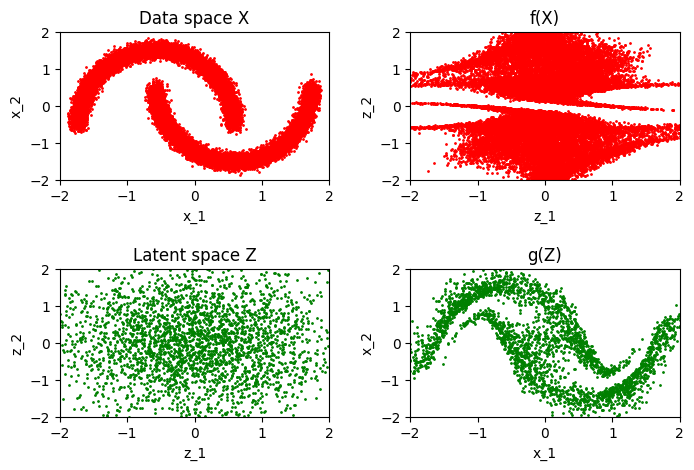

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7134
Epoch 72/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7144
Epoch 73/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7039
Epoch 74/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7064
Epoch 75/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7080
Epoch 76/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7141
Epoch 77/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6967
Epoch 78/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7037
Epoch 79/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7035
Epoch 80/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7039
Epoch 81/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7197
Saved to ./output/generated_img_080.png


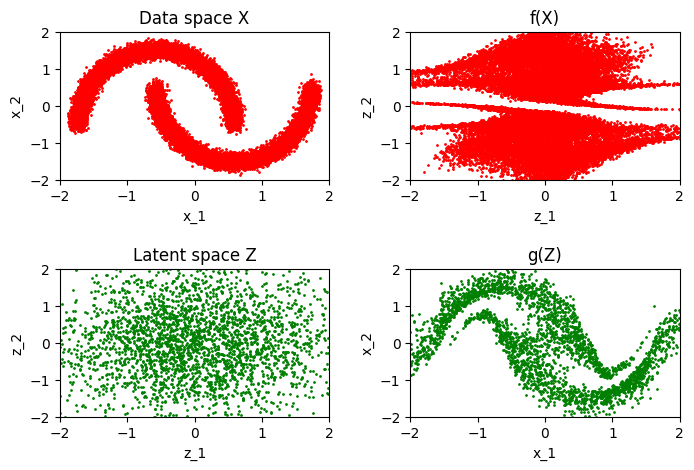

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7195
Epoch 82/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7072
Epoch 83/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7102
Epoch 84/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7135
Epoch 85/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7070
Epoch 86/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7274
Epoch 87/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7031
Epoch 88/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7069
Epoch 89/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7165
Epoch 90/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7173
Epoch 91/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7093
Saved to ./output/generated_img_090.png


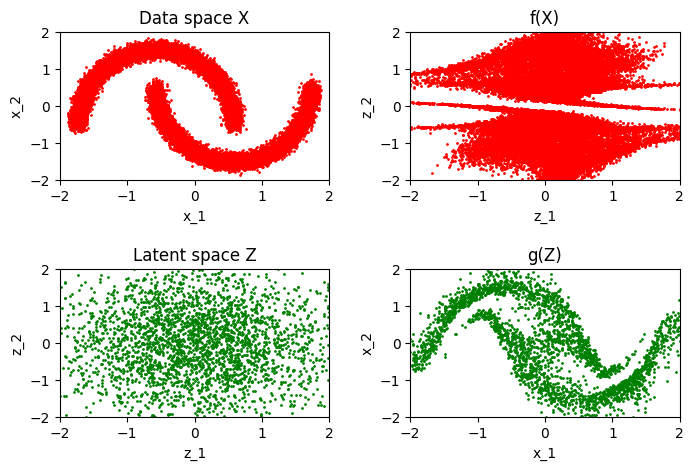

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7093
Epoch 92/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7045
Epoch 93/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7144
Epoch 94/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7044
Epoch 95/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7055
Epoch 96/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7099
Epoch 97/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7075
Epoch 98/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7206
Epoch 99/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7163
Epoch 100/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7130
Epoch 101/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6984
Saved to ./output/generated_img_100.png


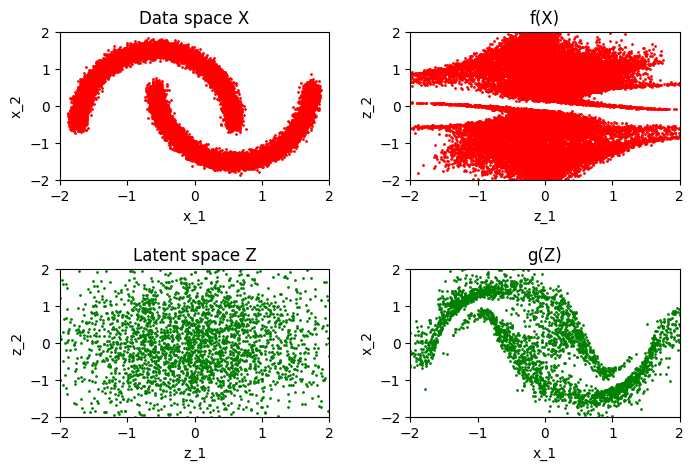

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6986
Epoch 102/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7076
Epoch 103/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7013
Epoch 104/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6942
Epoch 105/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7116
Epoch 106/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7094
Epoch 107/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7061
Epoch 108/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6979
Epoch 109/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7107
Epoch 110/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7319
Epoch 111/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6962
Saved to ./output/generated_img_110.png


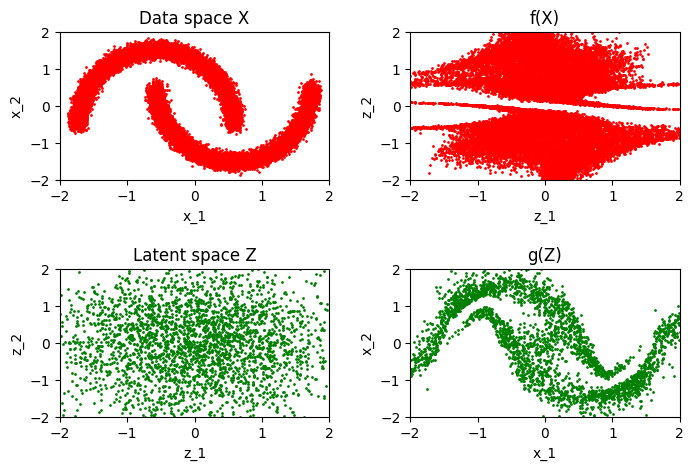

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6965
Epoch 112/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7017
Epoch 113/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6947
Epoch 114/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7041
Epoch 115/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7058
Epoch 116/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7215
Epoch 117/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7108
Epoch 118/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7116
Epoch 119/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7126
Epoch 120/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7072
Epoch 121/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7108
Saved to ./output/generated_img_120.png


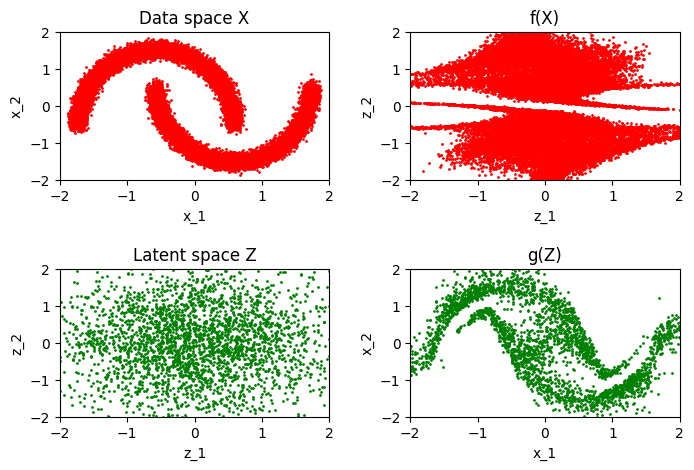

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7107
Epoch 122/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7030
Epoch 123/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7030
Epoch 124/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7047
Epoch 125/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7093
Epoch 126/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7074
Epoch 127/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7050
Epoch 128/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7050
Epoch 129/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7014
Epoch 130/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7056
Epoch 131/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6923
Saved to ./output/generated_img_130.png


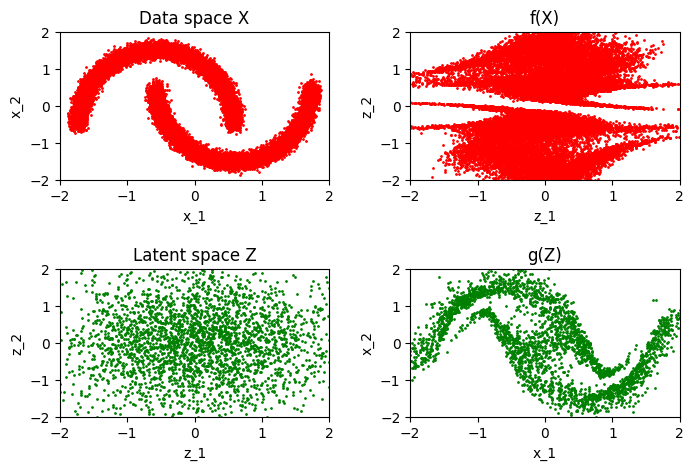

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6925
Epoch 132/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7109
Epoch 133/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7074
Epoch 134/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7013
Epoch 135/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7072
Epoch 136/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7037
Epoch 137/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7036
Epoch 138/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7103
Epoch 139/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7073
Epoch 140/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6997
Epoch 141/300
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7049
Saved to ./output/generated_img_140.png


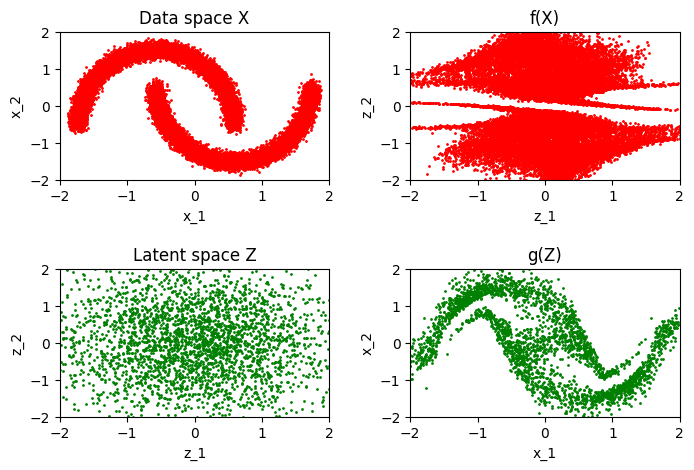

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7047
Epoch 142/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6986
Epoch 143/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6971
Epoch 144/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7009
Epoch 145/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7152
Epoch 146/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6940
Epoch 147/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7079
Epoch 148/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6907
Epoch 149/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6974
Epoch 150/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7026
Epoch 151/300
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6992
Saved to ./output/generated_img_150.png


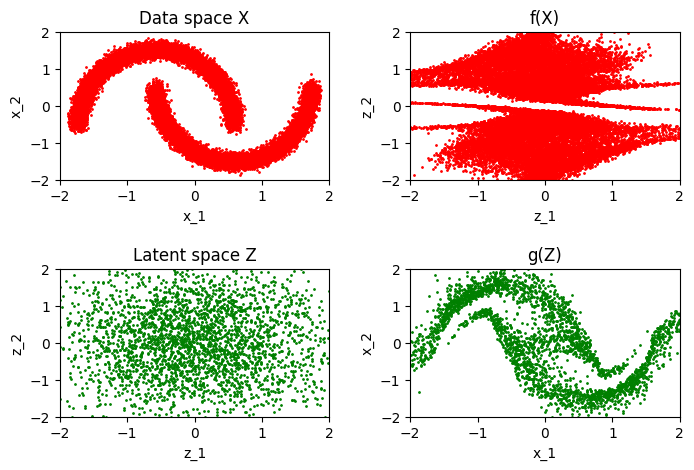

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6993
Epoch 152/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7153
Epoch 153/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7072
Epoch 154/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7067
Epoch 155/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7003
Epoch 156/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7069
Epoch 157/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7024
Epoch 158/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7022
Epoch 159/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7058
Epoch 160/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6994
Epoch 161/300
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6947
Saved to ./output/generated_img_160.png


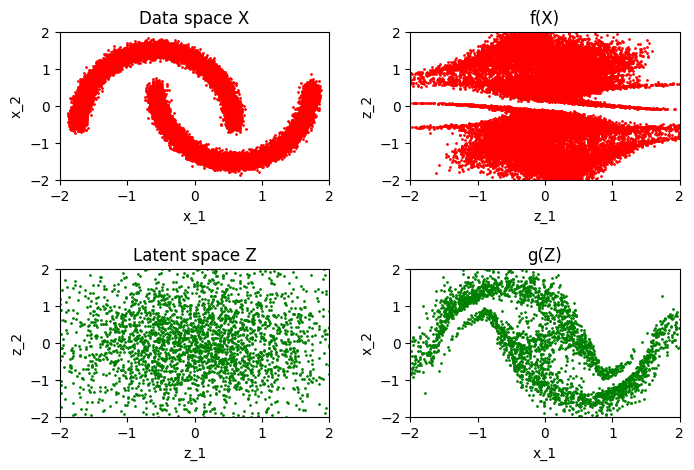

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6950
Epoch 162/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7017
Epoch 163/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7076
Epoch 164/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7070
Epoch 165/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7010
Epoch 166/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7016
Epoch 167/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7066
Epoch 168/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7034
Epoch 169/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7153
Epoch 170/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7121
Epoch 171/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7023
Saved to ./output/generated_img_170.png


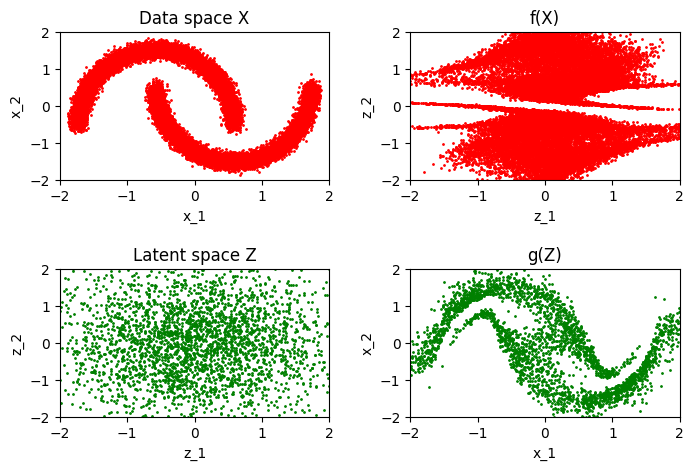

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7023
Epoch 172/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7012
Epoch 173/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7094
Epoch 174/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7104
Epoch 175/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7030
Epoch 176/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6978
Epoch 177/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7014
Epoch 178/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7080
Epoch 179/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7063
Epoch 180/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7028
Epoch 181/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7095
Saved to ./output/generated_img_180.png


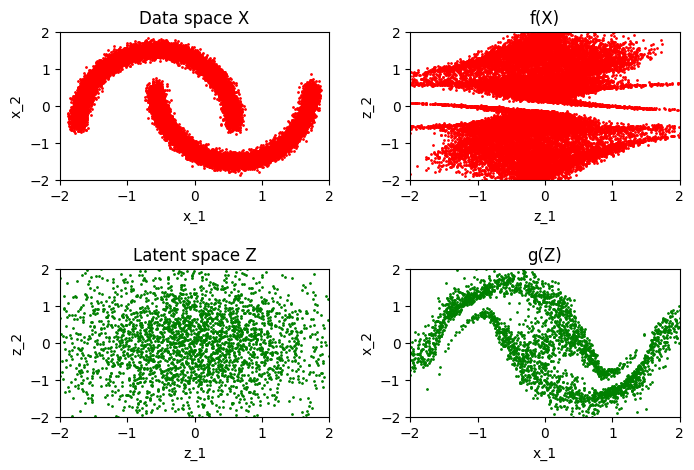

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.7094
Epoch 182/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7054
Epoch 183/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7098
Epoch 184/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7012
Epoch 185/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7029
Epoch 186/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7000
Epoch 187/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7055
Epoch 188/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7112
Epoch 189/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6984
Epoch 190/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6991
Epoch 191/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7018
Saved to ./output/generated_img_190.png


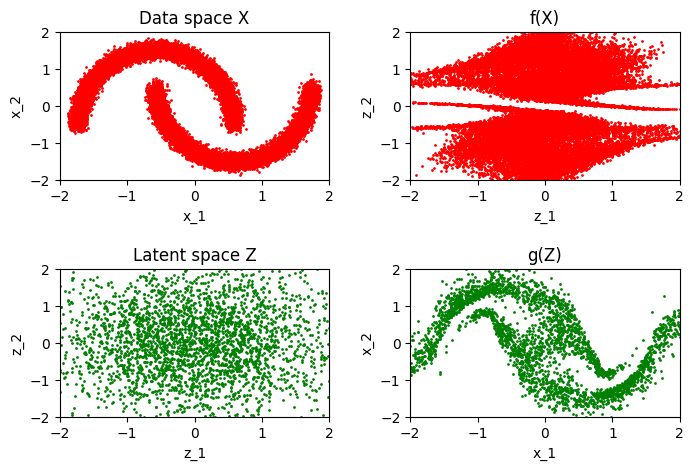

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7017
Epoch 192/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6970
Epoch 193/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7256
Epoch 194/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7026
Epoch 195/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7008
Epoch 196/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7203
Epoch 197/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7004
Epoch 198/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6996
Epoch 199/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7011
Epoch 200/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6937
Epoch 201/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7012
Saved to ./output/generated_img_200.png


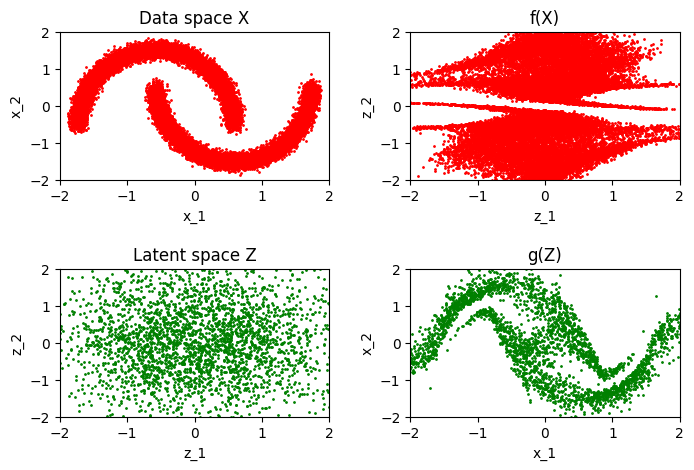

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7012
Epoch 202/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7015
Epoch 203/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7067
Epoch 204/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7109
Epoch 205/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7002
Epoch 206/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6981
Epoch 207/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7178
Epoch 208/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6984
Epoch 209/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7072
Epoch 210/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7112
Epoch 211/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6967
Saved to ./output/generated_img_210.png


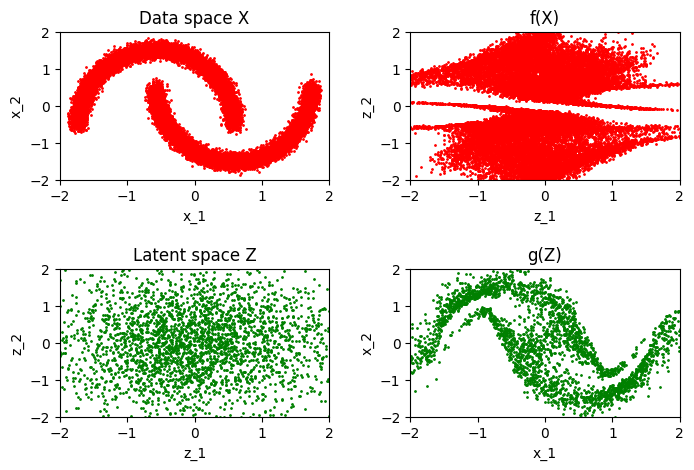

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6967
Epoch 212/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7073
Epoch 213/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7053
Epoch 214/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7082
Epoch 215/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7010
Epoch 216/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6964
Epoch 217/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7040
Epoch 218/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6986
Epoch 219/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6988
Epoch 220/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7101
Epoch 221/300
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6987
Saved to ./output/generated_img_220.png


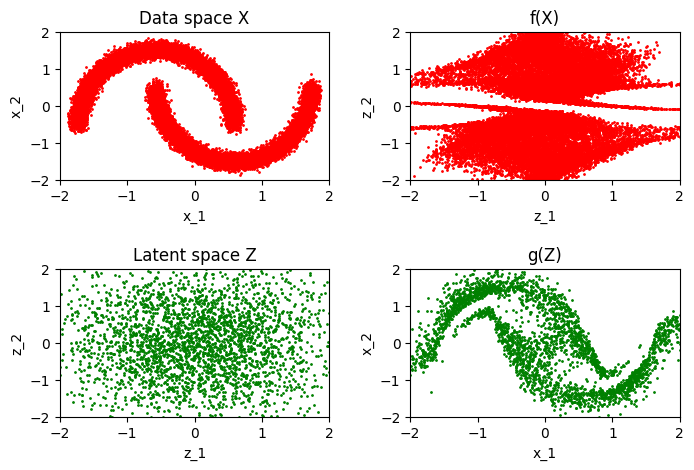

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.6988
Epoch 222/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6998
Epoch 223/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7025
Epoch 224/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7094
Epoch 225/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7036
Epoch 226/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6977
Epoch 227/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7126
Epoch 228/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7062
Epoch 229/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7007
Epoch 230/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6957
Epoch 231/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7005
Saved to ./output/generated_img_230.png


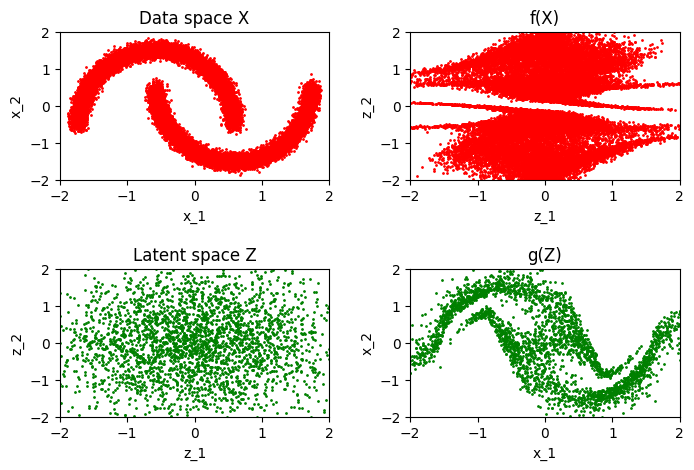

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7006
Epoch 232/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6995
Epoch 233/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7020
Epoch 234/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7027
Epoch 235/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7066
Epoch 236/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7046
Epoch 237/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6965
Epoch 238/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7001
Epoch 239/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7005
Epoch 240/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7111
Epoch 241/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6988
Saved to ./output/generated_img_240.png


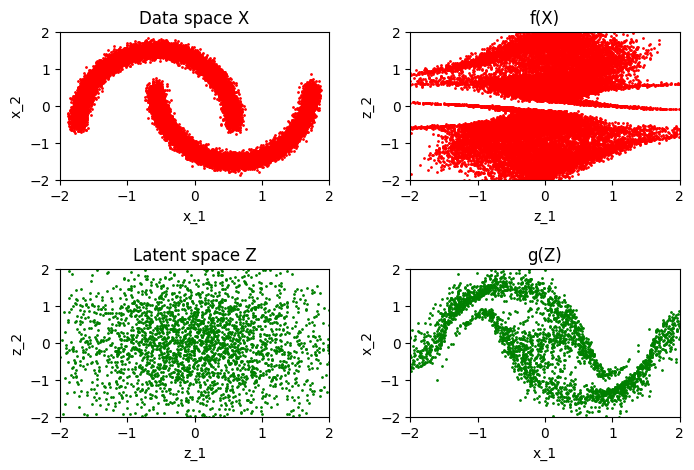

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.6988
Epoch 242/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6991
Epoch 243/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7025
Epoch 244/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7055
Epoch 245/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7095
Epoch 246/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6986
Epoch 247/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7062
Epoch 248/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7020
Epoch 249/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7031
Epoch 250/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7028
Epoch 251/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7092
Saved to ./output/generated_img_250.png


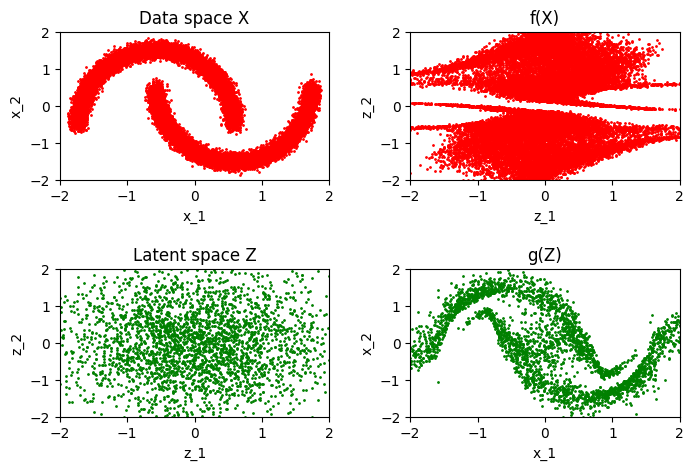

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7091
Epoch 252/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7083
Epoch 253/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6985
Epoch 254/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7029
Epoch 255/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7045
Epoch 256/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6961
Epoch 257/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6982
Epoch 258/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6957
Epoch 259/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7197
Epoch 260/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6980
Epoch 261/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6931
Saved to ./output/generated_img_260.png


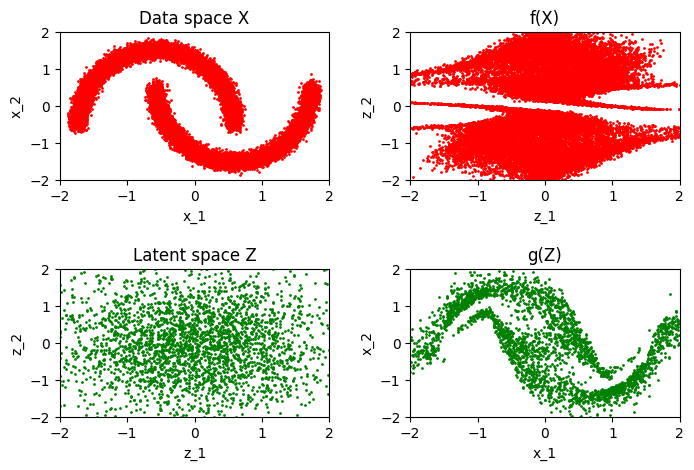

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6932
Epoch 262/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6984
Epoch 263/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6993
Epoch 264/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7075
Epoch 265/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7027
Epoch 266/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7015
Epoch 267/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7011
Epoch 268/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7017
Epoch 269/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6954
Epoch 270/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7048
Epoch 271/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7011
Saved to ./output/generated_img_270.png


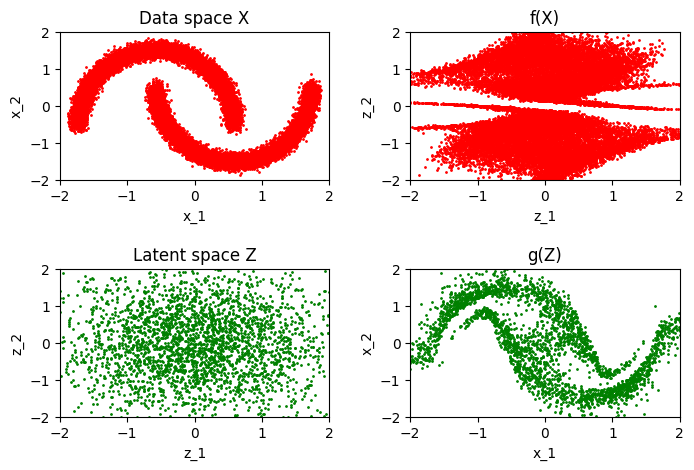

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7011
Epoch 272/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6916
Epoch 273/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6960
Epoch 274/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6984
Epoch 275/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7123
Epoch 276/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6990
Epoch 277/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6972
Epoch 278/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6963
Epoch 279/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7009
Epoch 280/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7077
Epoch 281/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7136
Saved to ./output/generated_img_280.png


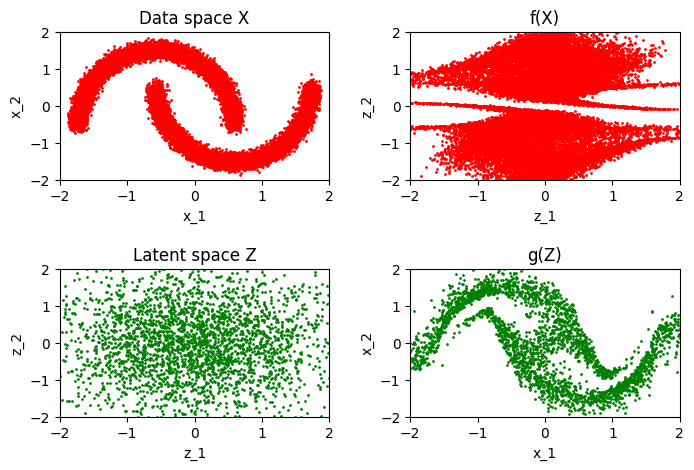

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7134
Epoch 282/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7041
Epoch 283/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7046
Epoch 284/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6963
Epoch 285/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6977
Epoch 286/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6880
Epoch 287/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6966
Epoch 288/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7086
Epoch 289/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6922
Epoch 290/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7046
Epoch 291/300
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7035
Saved to ./output/generated_img_290.png


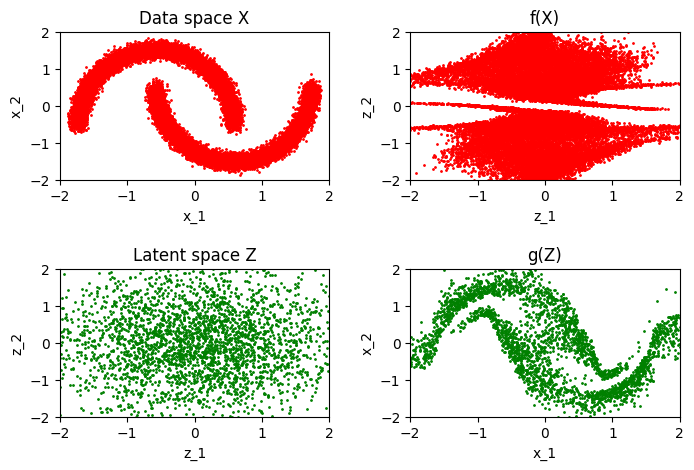

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7035
Epoch 292/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7037
Epoch 293/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7062
Epoch 294/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7042
Epoch 295/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6979
Epoch 296/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7082
Epoch 297/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6992
Epoch 298/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7020
Epoch 299/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7012
Epoch 300/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6962


In [20]:
import os

# Ensure the output directory exists
os.makedirs("./output", exist_ok=True)

model.fit(
    normalized_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [21]:
x, z, samples = img_generator_callback.generate()

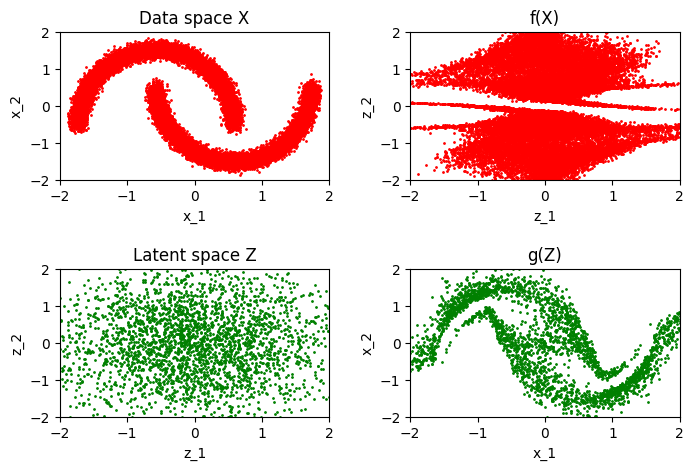

In [22]:
img_generator_callback.display(x, z, samples)

In [ ]:
pip install "tensorflow-probability[tensorflow]"


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip uninstall tensorflow-probability -y
!pip install tensorflow-probability[tensorflow]


Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
zsh:1: no matches found: tensorflow-probability[tensorflow]


In [ ]:
%pip install --upgrade "tensorflow-probability[tensorflow]"


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
Epoch 0, Loss: -0.6798394918441772
Epoch 100, Loss: -86341240.0
Epoch 200, Loss: -12472159232.0
Epoch 300, Loss: -282928644096.0
Epoch 400, Loss: -2779536424960.0
Epoch 500, Loss: -14644337967104.0


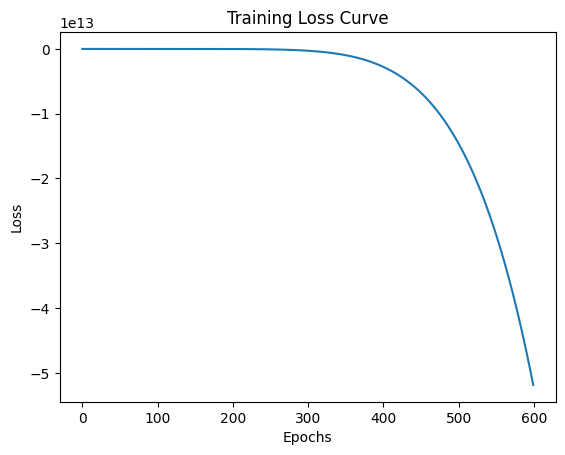

In [23]:
# Import necessary libraries
%load_ext autoreload
%autoreload 2

%pip install --upgrade numpy matplotlib scikit-learn tensorflow tensorflow-probability

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tfd = tfp.distributions

# Generate the dataset
n_samples = 1000
data, _ = datasets.make_moons(n_samples=n_samples, noise=0.05)
data = data.astype("float32")

# Define the custom Coupling layer
class CouplingLayer(layers.Layer):
    def __init__(self, units):
        super(CouplingLayer, self).__init__()
        self.scale_net = tf.keras.Sequential([
            layers.Dense(units, activation="relu"),
            layers.Dense(units, activation="relu"),
            layers.Dense(1, activation="tanh")
        ])
        self.translation_net = tf.keras.Sequential([
            layers.Dense(units, activation="relu"),
            layers.Dense(units, activation="relu"),
            layers.Dense(1)
        ])

    def call(self, x, reverse=False):
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=1)
        scale = self.scale_net(x1)
        translation = self.translation_net(x1)
        if reverse:
            x2 = (x2 - translation) * tf.exp(-scale)
        else:
            x2 = x2 * tf.exp(scale) + translation
        return tf.concat([x1, x2], axis=1)

# Define the RealNVP model
class RealNVP(Model):
    def __init__(self, num_coupling_layers, units):
        super(RealNVP, self).__init__()
        self.coupling_layers = [CouplingLayer(units) for _ in range(num_coupling_layers)]

    def call(self, x, reverse=False):
        for layer in (reversed(self.coupling_layers) if reverse else self.coupling_layers):
            x = layer(x, reverse=reverse)
        return x

# Instantiate and compile the model
num_coupling_layers = 6
units = 128
realnvp = RealNVP(num_coupling_layers, units)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = lambda x: -tf.reduce_mean(realnvp(x) ** 2)

# Training loop
epochs = 600
losses = []

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(data)
    grads = tape.gradient(loss, realnvp.trainable_variables)
    optimizer.apply_gradients(zip(grads, realnvp.trainable_variables))
    losses.append(loss.numpy())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Plot the loss curve
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-03-30 16:01:28.417369: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0, Loss: -601374.1875


2025-03-30 16:01:30.300402: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-30 16:01:33.992068: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-30 16:01:41.207893: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-30 16:01:55.410170: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-30 16:02:23.716960: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-30 16:03:20.581501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100, Loss: nan


2025-03-30 16:05:13.403844: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 200, Loss: nan


2025-03-30 16:08:54.783266: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300, Loss: nan
Epoch 400, Loss: nan
Epoch 500, Loss: nan


2025-03-30 16:16:28.180586: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


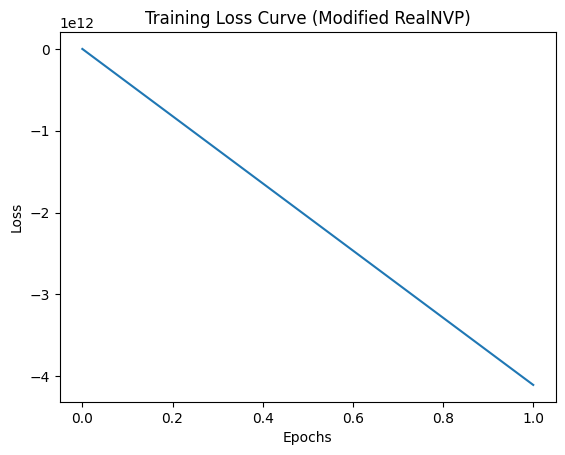

In [ ]:
# -----------------------------------------------------
# Import necessary libraries
# -----------------------------------------------------
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tfd = tfp.distributions

# -----------------------------------------------------
# Set random seeds for reproducibility (optional)
# -----------------------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------------------------------
# Generate the dataset
# -----------------------------------------------------
n_samples = 1000
data, _ = datasets.make_moons(n_samples=n_samples, noise=0.05)
data = data.astype("float32")

# -----------------------------------------------------
# Hyperparameters (feel free to tweak!)
# -----------------------------------------------------
num_coupling_layers = 8  # Changed from 6 to 8
units = 64               # Changed from 128 to 64
batch_size = 64
epochs = 600
learning_rate = 0.0005   # Slightly different LR
steps_per_epoch = len(data) // batch_size

# -----------------------------------------------------
# Define a modified Coupling layer
# -----------------------------------------------------
class CouplingLayer(layers.Layer):
    def __init__(self, units):
        super().__init__()
        # scale_net with ELU activations and no final tanh
        self.scale_net = tf.keras.Sequential([
            layers.Dense(units, activation="elu"),
            layers.Dense(units, activation="elu"),
            layers.Dense(1)  # no tanh here
        ])
        # translation_net also uses ELU
        self.translation_net = tf.keras.Sequential([
            layers.Dense(units, activation="elu"),
            layers.Dense(units, activation="elu"),
            layers.Dense(1)
        ])

    def call(self, x, reverse=False):
        # Split x into two parts
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=1)
        # Compute scale and translation from x1
        scale = self.scale_net(x1)
        translation = self.translation_net(x1)

        if reverse:
            # Inverse pass
            x2 = (x2 - translation) * tf.exp(-scale)
        else:
            # Forward pass
            x2 = x2 * tf.exp(scale) + translation

        return tf.concat([x1, x2], axis=1)

# -----------------------------------------------------
# Define the RealNVP model
# -----------------------------------------------------
class RealNVP(Model):
    def __init__(self, num_coupling_layers, units):
        super().__init__()
        self.coupling_layers = [
            CouplingLayer(units) for _ in range(num_coupling_layers)
        ]

    def call(self, x, reverse=False):
        if reverse:
            # Apply layers in reverse order
            for layer in reversed(self.coupling_layers):
                x = layer(x, reverse=True)
        else:
            # Forward pass
            for layer in self.coupling_layers:
                x = layer(x, reverse=False)
        return x

# -----------------------------------------------------
# Instantiate the model, optimizer, and loss function
# -----------------------------------------------------
realnvp = RealNVP(num_coupling_layers, units)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# A toy loss: we try to transform the data to something close to zero,
# effectively measuring the mean squared value of the output.
def loss_fn(x):
    return tf.reduce_mean(tf.square(realnvp(x)))


# -----------------------------------------------------
# Prepare mini-batches
# -----------------------------------------------------
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000, seed=SEED)
dataset = dataset.batch(batch_size, drop_remainder=True)

# -----------------------------------------------------
# Training loop
# -----------------------------------------------------
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for step, batch_data in enumerate(dataset):
        with tf.GradientTape() as tape:
            loss = loss_fn(batch_data)
        grads = tape.gradient(loss, realnvp.trainable_variables)
        optimizer.apply_gradients(zip(grads, realnvp.trainable_variables))
        epoch_loss += loss.numpy()
    
    epoch_loss /= (step + 1)
    losses.append(epoch_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

# -----------------------------------------------------
# Plot the loss curve
# -----------------------------------------------------
plt.plot(losses)
plt.title("Training Loss Curve (Modified RealNVP)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 100, Loss: 0.5012
Epoch 200, Loss: 0.5018
Epoch 300, Loss: 0.4963
Epoch 400, Loss: 0.5019


2025-03-30 16:39:52.733371: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 500, Loss: 0.5009
Epoch 600, Loss: 0.5010


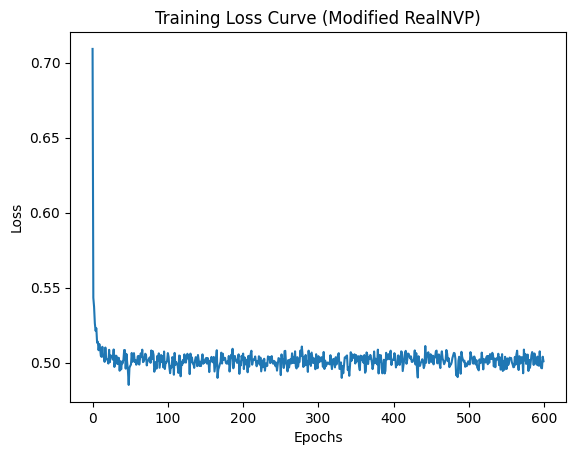

In [25]:
# -----------------------------------------------------
# Import necessary libraries
# -----------------------------------------------------
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
tfd = tfp.distributions

# -----------------------------------------------------
# Set random seeds for reproducibility (optional)
# -----------------------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------------------------------
# Generate the dataset
# -----------------------------------------------------
n_samples = 1000
data, _ = datasets.make_moons(n_samples=n_samples, noise=0.05)
data = data.astype("float32")

# -----------------------------------------------------
# Hyperparameters
# -----------------------------------------------------
num_coupling_layers = 8  # or any number you like
units = 64               # or any number you like
batch_size = 64
epochs = 600
learning_rate = 1e-4     # smaller LR to avoid instability

# -----------------------------------------------------
# Define a modified Coupling layer
# -----------------------------------------------------
class CouplingLayer(layers.Layer):
    def __init__(self, units):
        super().__init__()
        # scale_net with ELU activations
        self.scale_net = tf.keras.Sequential([
            layers.Dense(units, activation="elu"),
            layers.Dense(units, activation="elu"),
            layers.Dense(1)  
        ])
        # translation_net also uses ELU
        self.translation_net = tf.keras.Sequential([
            layers.Dense(units, activation="elu"),
            layers.Dense(units, activation="elu"),
            layers.Dense(1)
        ])

    def call(self, x, reverse=False):
        # Split x into two parts
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=1)
        # Compute scale and translation from x1
        scale = self.scale_net(x1)
        translation = self.translation_net(x1)

        if reverse:
            # Inverse pass
            x2 = (x2 - translation) * tf.exp(-scale)
        else:
            # Forward pass
            x2 = x2 * tf.exp(scale) + translation

        return tf.concat([x1, x2], axis=1)

# -----------------------------------------------------
# Define the RealNVP model
# -----------------------------------------------------
class RealNVP(Model):
    def __init__(self, num_coupling_layers, units):
        super().__init__()
        self.coupling_layers = [
            CouplingLayer(units) for _ in range(num_coupling_layers)
        ]

    def call(self, x, reverse=False):
        if reverse:
            # Apply layers in reverse order
            for layer in reversed(self.coupling_layers):
                x = layer(x, reverse=True)
        else:
            # Forward pass
            for layer in self.coupling_layers:
                x = layer(x, reverse=False)
        return x

# -----------------------------------------------------
# Instantiate the model, optimizer, and loss function
# -----------------------------------------------------
realnvp = RealNVP(num_coupling_layers, units)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# We want the output of realnvp(x) to be near 0 => minimize mean squared error
def loss_fn(x):
    return tf.reduce_mean(tf.square(realnvp(x)))

# -----------------------------------------------------
# Prepare mini-batches
# -----------------------------------------------------
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000, seed=SEED)
dataset = dataset.batch(batch_size, drop_remainder=True)

# -----------------------------------------------------
# Training loop
# -----------------------------------------------------
losses = []
num_batches = len(data) // batch_size  # how many batches per epoch

for epoch in range(epochs):
    epoch_loss = 0.0
    for step, batch_data in enumerate(dataset):
        with tf.GradientTape() as tape:
            loss = loss_fn(batch_data)
        grads = tape.gradient(loss, realnvp.trainable_variables)
        optimizer.apply_gradients(zip(grads, realnvp.trainable_variables))
        epoch_loss += loss.numpy()
    
    # Average loss for this epoch
    epoch_loss /= (step + 1)
    losses.append(epoch_loss)

    # Print every 100 epochs, including the last one
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

# -----------------------------------------------------
# Plot the loss curve
# -----------------------------------------------------
plt.plot(losses)
plt.title("Training Loss Curve (Modified RealNVP)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
